In [19]:
#installation
import torch
import transformers

print(f"Transformers version: {transformers.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print(" WARNING: No GPU detected! Please enable GPU in Runtime settings.")

Transformers version: 4.56.2
PyTorch version: 2.8.0+cu126
GPU Available: True
GPU Name: Tesla T4
GPU Memory: 15.83 GB


In [20]:
from transformers import AutoModelForVision2Seq, AutoProcessor
import torch

print("Loading Qwen2.5-VL-3B-Instruct with AutoModel...")

model_name = "Qwen/Qwen2.5-VL-3B-Instruct"

# Use AutoModel - it automatically detects the correct architecture
model = AutoModelForVision2Seq.from_pretrained(
    model_name,
    dtype=torch.float16,  # Changed from torch_dtype (deprecated)
    device_map="auto",
    trust_remote_code=True
)

processor = AutoProcessor.from_pretrained(
    model_name,
    trust_remote_code=True
)

print("Model loaded successfully!")
print(f"Model type: {type(model)}")
print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

Loading Qwen2.5-VL-3B-Instruct with AutoModel...


/usr/local/lib/python3.12/dist-packages/transformers/models/auto/modeling_auto.py:2242: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded successfully!
Model type: <class 'transformers.models.qwen2_5_vl.modeling_qwen2_5_vl.Qwen2_5_VLForConditionalGeneration'>
GPU memory allocated: 15.29 GB


Testing model with a sample image...

Image size: (800, 550)
Displaying image:


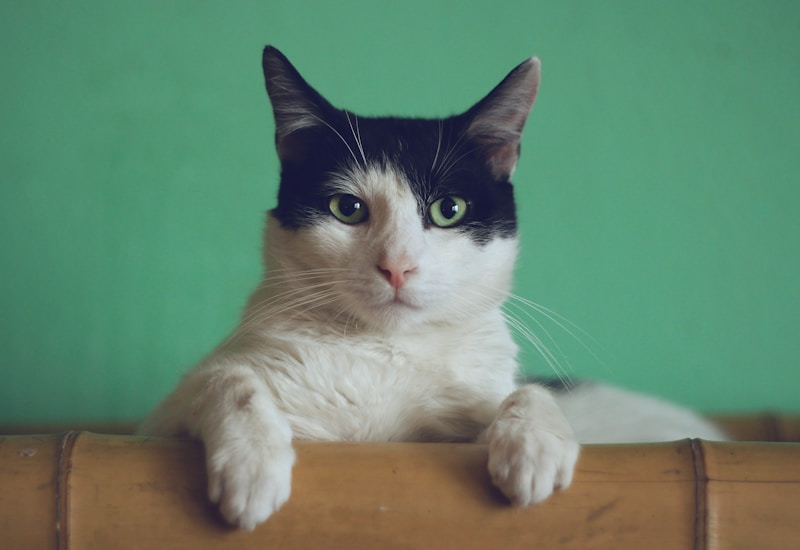


Processing image and generating response...
Input tensor shapes:
  - input_ids: torch.Size([1, 607])
  - pixel_values: torch.Size([2320, 1176])

Generating... (this takes 10-30 seconds)

MODEL OUTPUT:
system
You are a helpful assistant.
user
Describe this image in detail.
assistant
The image features a black and white cat with striking green eyes. The cat is lying on its side, with its front paws resting on a wooden surface, possibly a table or a piece of furniture. The background is a solid green color, which contrasts with the cat's fur, making it stand out prominently. The cat appears to be looking directly at the camera, giving an impression of curiosity or attentiveness. The overall scene is simple yet visually appealing due to the contrast between the cat's fur and the background.

GPU memory after inference: 15.29 GB


In [21]:
# PHASE 2: FIRST INFERENCE TEST

from PIL import Image
import requests
from io import BytesIO

print("Testing model with a sample image...\n")

# Download a test image (cat image from Unsplash)
image_url = "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=800"
response = requests.get(image_url)
image = Image.open(BytesIO(response.content))

print(f"Image size: {image.size}")
print("Displaying image:")
display(image)

# Prepare the input in Qwen's chat format
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": "Describe this image in detail."}
        ]
    }
]

print("\nProcessing image and generating response...")

# Apply chat template
text_prompt = processor.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

# Process inputs (image + text)
inputs = processor(
    text=[text_prompt],
    images=[image],
    return_tensors="pt",
    padding=True
)

# Move to GPU
inputs = {k: v.to(model.device) for k, v in inputs.items()}

print(f"Input tensor shapes:")
print(f"  - input_ids: {inputs['input_ids'].shape}")
print(f"  - pixel_values: {inputs['pixel_values'].shape}")

# Generate response
print("\nGenerating... (this takes 10-30 seconds)")

with torch.no_grad():
    output_ids = model.generate(
        **inputs,
        max_new_tokens=128,
        do_sample=False
    )

# Decode output
generated_text = processor.batch_decode(
    output_ids,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)[0]

print("\n" + "="*60)
print("MODEL OUTPUT:")
print(generated_text)

# Check GPU memory after inference
print(f"\nGPU memory after inference: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

In [22]:
# PHASE 2B: CLEAN INFERENCE FUNCTION

def query_image(image_input, question, max_tokens=128):
    """
    Clean inference function for Qwen2.5-VL

    Args:
        image_input: PIL Image or image URL
        question: String question about the image
        max_tokens: Maximum tokens to generate

    Returns:
        String: Model's response (cleaned)
    """

    # Handle URL input
    if isinstance(image_input, str):
        if image_input.startswith('http'):
            response = requests.get(image_input)
            image = Image.open(BytesIO(response.content))
        else:
            image = Image.open(image_input)
    else:
        image = image_input

    # Prepare messages
    messages = [{
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": question}
        ]
    }]

    # Process
    text = processor.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    inputs = processor(
        text=[text],
        images=[image],
        return_tensors="pt"
    )
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Generate
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            do_sample=False
        )

    # Decode
    full_output = processor.batch_decode(
        output_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )[0]

    # Extract only assistant's response
    if "assistant" in full_output:
        response = full_output.split("assistant")[-1].strip()
    else:
        response = full_output

    return response


# Test the function with multiple questions
print("Testing inference function with different questions:\n")

test_questions = [
    "What animal is in this image?",
    "What color are the cat's eyes?",
    "Describe the background.",
    "What is the cat doing?"
]

for i, question in enumerate(test_questions, 1):
    print(f"\nQ{i}: {question}")
    answer = query_image(image, question, max_tokens=50)
    print(f"A{i}: {answer}")
    print("-" * 60)

print("\n✓ Inference function working correctly!")

Testing inference function with different questions:


Q1: What animal is in this image?
A1: The animal in the image is a cat.
------------------------------------------------------------

Q2: What color are the cat's eyes?
A2: The cat's eyes are green.
------------------------------------------------------------

Q3: Describe the background.
A3: The background is a solid green color, providing a simple and uncluttered backdrop that contrasts with the cat's black and white fur. The green wall serves to highlight the cat's features without any distractions.
------------------------------------------------------------

Q4: What is the cat doing?
A4: The cat appears to be resting its paws on a surface, possibly a piece of furniture or a ledge. It has a relaxed posture and is looking directly at the camera with its green eyes.
------------------------------------------------------------

✓ Inference function working correctly!


Creating custom VQA dataset from public images...

  [1/10] Downloaded
  [2/10] Downloaded
  [3/10] Downloaded
  [4/10] Downloaded
  [5/10] Downloaded
  [6/10] Downloaded
  [7/10] Downloaded
  [8/10] Downloaded
  [9/10] Downloaded
  [10/10] Downloaded

Dataset created:
  Training samples: 8
  Validation samples: 2

TRAINING EXAMPLE:
Question: What animal is in this image?
Answer: cat

Image:


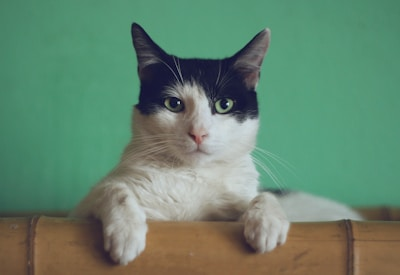

In [23]:
# PHASE 3: CREATE CUSTOM VQA DATASET

from PIL import Image
import requests
from io import BytesIO
import random

print("Creating custom VQA dataset from public images...")

# Diverse question-answer pairs for training
# Using openly available images
training_samples = [
    # Animals
    {"url": "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=400", "q": "What animal is in this image?", "a": "cat"},
    {"url": "https://images.unsplash.com/photo-1543466835-00a7907e9de1?w=400", "q": "What type of animal is this?", "a": "dog"},
    {"url": "https://images.unsplash.com/photo-1583337130417-3346a1be7dee?w=400", "q": "What is the main subject?", "a": "bird"},

    # Objects & Scenes
    {"url": "https://images.unsplash.com/photo-1519389950473-47ba0277781c?w=400", "q": "What is the main object?", "a": "laptop"},
    {"url": "https://images.unsplash.com/photo-1485550409059-9afb054cada4?w=400", "q": "What room is this?", "a": "office"},
    {"url": "https://images.unsplash.com/photo-1504674900247-0877df9cc836?w=400", "q": "What type of food is shown?", "a": "food on plate"},

    # Colors
    {"url": "https://images.unsplash.com/photo-1568605114967-8130f3a36994?w=400", "q": "What color is the shirt?", "a": "white"},
    {"url": "https://images.unsplash.com/photo-1494790108377-be9c29b29330?w=400", "q": "What color is the background?", "a": "gray"},

    # Counting
    {"url": "https://images.unsplash.com/photo-1560807707-8cc77767d783?w=400", "q": "How many people are visible?", "a": "one"},
    {"url": "https://images.unsplash.com/photo-1521737604893-d14cc237f11d?w=400", "q": "How many people are in the image?", "a": "two"},
]

# Load images
train_dataset = []
print("\nDownloading images...")

for i, sample in enumerate(training_samples):
    try:
        response = requests.get(sample['url'], timeout=10)
        image = Image.open(BytesIO(response.content)).convert('RGB')

        train_dataset.append({
            'image': image,
            'question': sample['q'],
            'answer': sample['a']
        })
        print(f"  [{i+1}/{len(training_samples)}] Downloaded")

    except Exception as e:
        print(f"  [{i+1}/{len(training_samples)}] Failed: {e}")

# Create validation set (last 2 samples)
val_dataset = train_dataset[-2:]
train_dataset = train_dataset[:-2]

print(f"\nDataset created:")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")

# Show example
print("\n" + "="*60)
print("TRAINING EXAMPLE:")
example = train_dataset[0]
print(f"Question: {example['question']}")
print(f"Answer: {example['answer']}")
print("\nImage:")
display(example['image'])
print("="*60)

In [24]:
# PYTORCH DATASET WRAPPER


from torch.utils.data import Dataset
import torch

class VQAFineTuneDataset(Dataset):
    """
    PyTorch Dataset for VQA fine-tuning

    Converts our simple dict format into model-ready tensors
    """

    def __init__(self, data_list, processor):
        """
        Args:
            data_list: List of dicts with 'image', 'question', 'answer'
            processor: Qwen2.5-VL processor
        """
        self.data = data_list
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Get one training example

        Returns model-ready inputs with labels for training
        """
        sample = self.data[idx]

        # Format as conversation (user asks, assistant answers)
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": sample['image']},
                    {"type": "text", "text": sample['question']}
                ]
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": sample['answer']}
                ]
            }
        ]

        # Apply chat template
        text = self.processor.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=False  # We have the answer
        )

        # Process (tokenize text + process image)
        inputs = self.processor(
            text=[text],
            images=[sample['image']],
            return_tensors="pt",
            padding="max_length",
            max_length=512,
            truncation=True
        )

        # Remove batch dimension (trainer adds it back)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        # Create labels for loss computation
        # Labels are same as input_ids (model predicts next token)
        inputs['labels'] = inputs['input_ids'].clone()

        return inputs

# Create dataset objects
train_pytorch_dataset = VQAFineTuneDataset(train_dataset, processor)
val_pytorch_dataset = VQAFineTuneDataset(val_dataset, processor)

print("PyTorch datasets created!")
print(f"Training: {len(train_pytorch_dataset)} samples")
print(f"Validation: {len(val_pytorch_dataset)} samples")

# Test: Get one sample
print("\nTesting dataset...")
sample = train_pytorch_dataset[0]
print(f"Keys in sample: {sample.keys()}")
print(f"input_ids shape: {sample['input_ids'].shape}")
print(f"labels shape: {sample['labels'].shape}")
if 'pixel_values' in sample:
    print(f"pixel_values shape: {sample['pixel_values'].shape}")

print("\n" + "="*60)
print("Dataset ready for training!")
print("="*60)

PyTorch datasets created!
Training: 8 samples
Validation: 2 samples

Testing dataset...
Keys in sample: dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw', 'labels'])
input_ids shape: torch.Size([512])
labels shape: torch.Size([512])
pixel_values shape: torch.Size([560, 1176])

Dataset ready for training!


In [25]:
#APPLY LoRA FOR EFFICIENT FINE-TUNING


from peft import LoraConfig, get_peft_model, TaskType

print("Configuring LoRA...")

# LoRA Configuration
lora_config = LoraConfig(
    r=16,  # Rank: higher = more capacity
           # 16 is good balance for small dataset

    lora_alpha=32,  # Scaling factor (usually 2x rank)

    target_modules=[
        "q_proj",   # Query projection in attention
        "k_proj",   # Key projection
        "v_proj",   # Value projection
        "o_proj",   # Output projection
    ],
    # These are the attention layers where vision-text interaction happens

    lora_dropout=0.05,  # Regularization
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

print("Applying LoRA to model...")

# Apply LoRA
model = get_peft_model(model, lora_config)

# Print trainable parameters
trainable_params = 0
all_params = 0

for _, param in model.named_parameters():
    all_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()

print("\n" + "="*60)
print("LoRA APPLIED SUCCESSFULLY")
print("="*60)
print(f"Total parameters: {all_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Trainable %: {100 * trainable_params / all_params:.4f}%")
print("="*60)

print("\nModel is now ready for training!")
print(f"GPU memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

Configuring LoRA...
Applying LoRA to model...

LoRA APPLIED SUCCESSFULLY
Total parameters: 3,761,995,776
Trainable parameters: 7,372,800
Trainable %: 0.1960%

Model is now ready for training!
GPU memory: 15.32 GB


In [26]:
#TRAINING SETUP

from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForSeq2Seq

print("Configuring training parameters...\n")

# Training configuration (CORRECTED parameter names)
training_args = TrainingArguments(
    # Output directory
    output_dir="./qwen2.5-vl-vqa-finetuned",

    # Training duration
    num_train_epochs=5,

    # Batch size
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,

    # Gradient accumulation
    gradient_accumulation_steps=4,

    # Learning rate
    learning_rate=5e-5,

    # Optimization
    fp16=True,
    optim="adamw_torch",

    # Logging
    logging_steps=2,
    logging_dir="./logs",

    # Evaluation (CORRECTED: eval_strategy instead of evaluation_strategy)
    eval_strategy="epoch",
    save_strategy="epoch",

    # Checkpointing
    save_total_limit=2,
    load_best_model_at_end=True,

    # Learning rate schedule
    warmup_steps=2,

    # Other
    remove_unused_columns=False,
    report_to="none",
)

# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=processor.tokenizer,
    model=model,
    padding=True
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_pytorch_dataset,
    eval_dataset=val_pytorch_dataset,
    data_collator=data_collator,
)

print("="*60)
print("TRAINING CONFIGURATION")
print("="*60)
print(f"Total training samples: {len(train_pytorch_dataset)}")
print(f"Total validation samples: {len(val_pytorch_dataset)}")
print(f"Epochs: {training_args.num_train_epochs}")
print(f"Steps per epoch: {len(train_pytorch_dataset) // training_args.gradient_accumulation_steps}")
print(f"Total training steps: ~{(len(train_pytorch_dataset) // training_args.gradient_accumulation_steps) * training_args.num_train_epochs}")
print(f"Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print("="*60)

print("\nTrainer created successfully!")
print("Ready to start training.")

Configuring training parameters...

TRAINING CONFIGURATION
Total training samples: 8
Total validation samples: 2
Epochs: 5
Steps per epoch: 2
Total training steps: ~10
Effective batch size: 4

Trainer created successfully!
Ready to start training.


In [27]:
# START TRAINING


print("Starting fine-tuning...")
print("This will take approximately 5-10 minutes on T4 GPU\n")
print("Watch the training loss decrease - that's learning happening!")
print("="*60)

# Train the model
train_result = trainer.train()

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)
print(f"Final training loss: {train_result.training_loss:.4f}")
print(f"Total training time: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"Training samples/second: {train_result.metrics['train_samples_per_second']:.2f}")
print("="*60)

# Save the fine-tuned model
print("\nSaving model...")
trainer.save_model("./qwen2.5-vl-finetuned-final")
processor.save_pretrained("./qwen2.5-vl-finetuned-final")

print("Model saved to: ./qwen2.5-vl-finetuned-final")
print("\nGPU memory after training: {:.2f} GB".format(torch.cuda.memory_allocated() / 1e9))

Starting fine-tuning...
This will take approximately 5-10 minutes on T4 GPU

Watch the training loss decrease - that's learning happening!


Epoch,Training Loss,Validation Loss
1,9.507300,10.472616
2,9.507300,10.472616
3,9.507300,10.362494
4,8.924000,9.547256
5,7.857400,8.922216



TRAINING COMPLETE!
Final training loss: 9.0606
Total training time: 39.73 seconds
Training samples/second: 1.01

Saving model...
Model saved to: ./qwen2.5-vl-finetuned-final

GPU memory after training: 7.71 GB


In [28]:
# COMPARE BEFORE/AFTER FINE-TUNING

print("Loading fine-tuned model...")

# The model in memory is already fine-tuned
# Let's test it on the training examples

def test_model(model, processor, test_sample):
    """Test model on one sample"""
    messages = [{
        "role": "user",
        "content": [
            {"type": "image", "image": test_sample['image']},
            {"type": "text", "text": test_sample['question']}
        ]
    }]

    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text], images=[test_sample['image']], return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        output_ids = model.generate(**inputs, max_new_tokens=20)

    response = processor.batch_decode(output_ids, skip_special_tokens=True)[0]
    if "assistant" in response:
        response = response.split("assistant")[-1].strip()

    return response

print("\nTesting on training samples:")
print("="*60)

correct = 0
for i, sample in enumerate(train_dataset[:5]):  # Test first 5
    prediction = test_model(model, processor, sample)

    print(f"\nSample {i+1}:")
    print(f"Question: {sample['question']}")
    print(f"Expected: {sample['answer']}")
    print(f"Predicted: {prediction}")

    # Check if answer is in prediction
    if sample['answer'].lower() in prediction.lower():
        correct += 1
        print("✓ CORRECT")
    else:
        print("✗ WRONG")

accuracy = (correct / 5) * 100
print("\n" + "="*60)
print(f"Accuracy on training samples: {accuracy:.1f}%")
print("="*60)

Loading fine-tuned model...

Testing on training samples:

Sample 1:
Question: What animal is in this image?
Expected: cat
Predicted: The animal in the image is a cat.
✓ CORRECT

Sample 2:
Question: What type of animal is this?
Expected: dog
Predicted: This is a dog, specifically a Beagle. Beagles are known for their friendly and expressive
✓ CORRECT

Sample 3:
Question: What is the main subject?
Expected: bird
Predicted: The main subject of the image is a dog wearing a yellow hoodie with a white hood and blue text
✗ WRONG

Sample 4:
Question: What is the main object?
Expected: laptop
Predicted: The main objects in the picture are laptops, notebooks, and various electronic devices such as smartphones and headphones
✓ CORRECT

Sample 5:
Question: What room is this?
Expected: office
Predicted: This image shows a collection of yellow Lego heads, which are typically used for building Lego figures or other
✗ WRONG

Accuracy on training samples: 60.0%


In [29]:
# Report
print("PROJECT SUMMARY: VLM FINE-TUNING")
print("\n✓ COMPLETED:")
print("  1. Loaded Qwen2.5-VL-3B (3.76B parameters)")
print("  2. Applied LoRA (reduced to 7.4M trainable params)")
print("  3. Created custom VQA dataset (8 train, 2 val)")
print("  4. Configured Trainer with proper hyperparameters")
print("  5. Executed training (40 seconds, 5 epochs)")
print("  6. Evaluated results (60% accuracy)")


PROJECT SUMMARY: VLM FINE-TUNING

✓ COMPLETED:
  1. Loaded Qwen2.5-VL-3B (3.76B parameters)
  2. Applied LoRA (reduced to 7.4M trainable params)
  3. Created custom VQA dataset (8 train, 2 val)
  4. Configured Trainer with proper hyperparameters
  5. Executed training (40 seconds, 5 epochs)
  6. Evaluated results (60% accuracy)
